In [1]:
%matplotlib inline 

In [2]:
pwd

'D:\\Users\\andre.ferreira\\Projects\\stocks\\prototypes'

In [3]:
cd ..

D:\Users\andre.ferreira\Projects\stocks


In [4]:
from matplotlib import pyplot as plt
import os
import sys
import platform
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
import seaborn as sns
from algos import meta5Ibov
from algos.util import progressbar
import torch as th

import talib as ta
from numba import jit
import importlib
from scipy.signal import hann
import torch as th

In [5]:
cd data

D:\Users\andre.ferreira\Projects\stocks\data


In [6]:
if platform.uname()[1] == 'andre-predator': 
    meta5Ibov.setDataPath('C:\\Users\\andre\\Projects\\stocks\\data', 
                        'C:\\Users\\andre\\Projects\\stocks\\data')
else:
    meta5Ibov.setDataPath('D:\\Users\\andre.ferreira\\Projects\\stocks\\data', 
                        'D:\\Users\\andre.ferreira\\Projects\\stocks\\data')


Master data loaded size (minutes):  508269
symbols loaded:
['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'DOL$' 'ITUB4' 'PETR4' 'VALE3' 'WIN@']


#### Using M1 Data but could be M15 data etc.

Saulo used 10 seconds interval

In [7]:
#meta5Ibov.loadMeta5Data(preload=False);
meta5Ibov.loadMeta5Data();
bars = meta5Ibov.getSymbol('WIN@')

Master data loaded size (minutes):  508269
symbols loaded:
['ABEV3' 'B3SA3' 'BBAS3' 'BBDC4' 'DOL$' 'ITUB4' 'PETR4' 'VALE3' 'WIN@']
Using previous loaded data!


Not enough memory on local machine

In [8]:
bars.drop(columns='S', inplace=True)
# thought about droping O since C close is the next open
# but it isnt true (ticks are commanding and that is not commom to happen)

In [9]:
bars.head()

,O,H,L,C,TV,RV
time,,,,,,
2014-01-02 10:06:00,80088.0,80118.0,80049.0,80088.0,1690,481
2014-01-02 10:07:00,80080.0,80080.0,80034.0,80049.0,670,184
2014-01-02 10:08:00,80041.0,80057.0,80010.0,80049.0,690,139
2014-01-02 10:09:00,80049.0,80049.0,80018.0,80026.0,210,43
2014-01-02 10:10:00,80034.0,80041.0,79632.0,79725.0,4740,1638


In [10]:
ntime=60*7*5*2 # one week 7hours day *5 days
print(ntime)

4200


In [11]:
#tbars = tbars[:ntime]

In [12]:
bars = bars[:ntime]

In [13]:
bars.dropna(inplace=True)
tbars = bars.copy()  

### make it stationary or try to

- Remove 6 hours trend (not that good)
- Make price diff with past
- Make more features for volume (since OHLC is 4 and TV/RV is just 2)

#### Normalize 6D { O, H, L, C, Log(c+TV), Log(c+RV) } Minute Bar Prices 

- tick is 5D { Ask, Bid, TV, RV, Tick-Flag } if not considering "last price"

In [14]:
bars.TV = np.log(10 + bars.TV) # must be not zero (make it like gaussian)
bars.RV = np.log(10 + bars.RV)

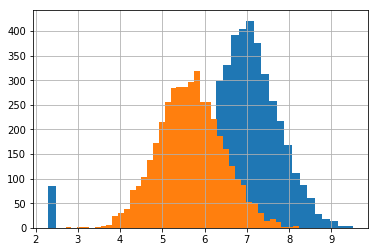

In [15]:
bars.TV.hist(bins=40);
bars.RV.hist(bins=40);

In [16]:
bars.columns

Index(['O', 'H', 'L', 'C', 'TV', 'RV'], dtype='object')

The awesome price returns 

In [17]:
bars.iloc[1:, :4] = bars.iloc[1:,:4].values-bars.iloc[:-1,:4].values

In [18]:
# two more classes for volume

In [19]:
bars.loc[1:, 'DTV'] = bars.TV.values[1:]-bars.TV.values[:-1]
bars.loc[1:, 'DRV'] = bars.RV.values[1:]-bars.RV.values[:-1]

In [20]:
bars.DRV /=  np.std(bars.DRV)
bars.DTV /=  np.std(bars.DTV)

mean 0 and std=1

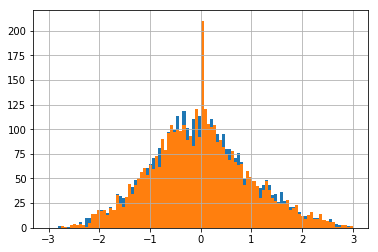

In [21]:
bars.DRV.hist(bins=100, range=[-3,3]);
bars.DTV.hist(bins=100, range=[-3,3]); # perfectly gaussian

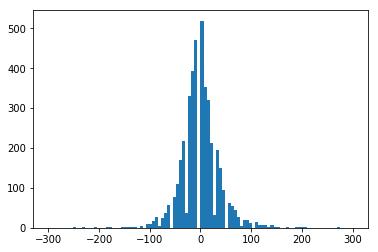

In [22]:
plt.hist(bars.H.values, bins=100, range=[-300,300]);

In [23]:
bars.TV = (bars.TV - np.mean(bars.TV))/np.std(bars.TV)
bars.RV = (bars.RV - np.mean(bars.RV))/np.std(bars.RV)

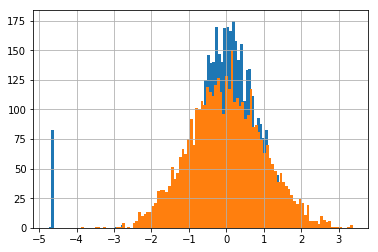

In [24]:
bars.TV.hist(bins=100);
bars.RV.hist(bins=100);

### Turn it in classes

In [25]:
from scipy.stats import laplace, norm

In [26]:
#laplace.fit(bars.C)#np.std(bars.C.values) # (u=-6.621795328113057e-09,b= 31.67682539343383) # b=30 average OHLC

In [27]:
nclass=100

In [28]:
laplace_bins = laplace.ppf(np.linspace(0, 1, nclass), 0, scale=30)
gaus_bins = norm.ppf(np.linspace(0, 1, nclass))

In [29]:
bars.fillna(0, inplace=True)

In [30]:
bars.columns

Index(['O', 'H', 'L', 'C', 'TV', 'RV', 'DTV', 'DRV'], dtype='object')

In [31]:
bars.describe()

,O,H,L,C,TV,RV,DTV,DRV
count,4200.000000,4200.000000,4200.000000,4200.000000,4.200000e+03,4.200000e+03,4200.000000,4200.000000
mean,18.363095,18.370476,18.361429,18.366905,-1.953838e-14,1.170889e-15,-0.000249,-0.000276
std,1236.526102,1236.915346,1235.883017,1236.539725,1.000119e+00,1.000119e+00,1.000000,1.000000
min,-417.000000,-386.000000,-401.000000,-386.000000,-4.748501e+00,-3.879682e+00,-6.767480,-3.540180
25%,-23.000000,-23.000000,-16.000000,-23.000000,-4.400416e-01,-6.834261e-01,-0.652981,-0.659367
50%,0.000000,0.000000,0.000000,0.000000,6.639988e-02,-1.021839e-02,-0.017877,-0.041002
75%,23.000000,16.000000,23.000000,23.000000,5.802207e-01,6.666580e-01,0.592875,0.614882
max,80088.000000,80118.000000,80049.000000,80088.000000,2.663750e+00,3.377679e+00,5.804142,4.473022


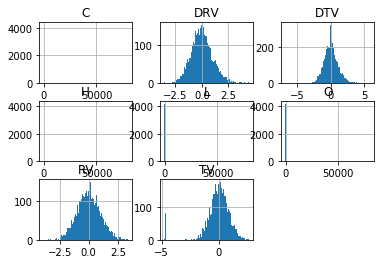

In [32]:
bars.hist(bins=100);

In [33]:
sbarsn = bars.values

In [34]:
print(sbarsn[:3])

[[ 8.00880000e+04  8.01180000e+04  8.00490000e+04  8.00880000e+04
   5.32931584e-01  7.01900409e-01  0.00000000e+00  0.00000000e+00]
 [-8.00000000e+00 -3.80000000e+01 -1.50000000e+01 -3.90000000e+01
  -4.09342114e-01 -5.17684789e-01 -1.13143365e+00 -1.08998117e+00]
 [-3.90000000e+01 -2.30000000e+01 -2.40000000e+01  0.00000000e+00
  -3.79532587e-01 -8.64301042e-01  3.57937427e-02 -3.09781710e-01]]


### Turn in classes  - Discretize or Bucktize

- Using a equal space division of space based on a gaussian and laplace distribution
- This already clips outliers

In [35]:
ohlc = np.digitize(sbarsn[:,:4], laplace_bins)
ohlc

array([[99, 99, 99, 99],
       [38, 14, 31, 14],
       [14, 23, 23, 50],
       ...,
       [91, 38, 91, 50],
       [60, 62, 50, 50],
       [50, 77, 62, 70]], dtype=int64)

In [36]:
tvrvs = np.digitize(sbarsn[:,4:], gaus_bins)
tvrvs

array([[70, 76, 50, 50],
       [34, 30, 13, 14],
       [35, 20, 51, 38],
       ...,
       [ 9,  4,  4,  5],
       [22, 14, 76, 73],
       [37, 28, 70, 67]], dtype=int64)

In [37]:
sbarsn[:, :4] = ohlc[:,:]
sbarsn[:, 4:] = tvrvs[:,:]

In [38]:
sbarsn[:3]

array([[99., 99., 99., 99., 70., 76., 50., 50.],
       [38., 14., 31., 14., 34., 30., 13., 14.],
       [14., 23., 23., 50., 35., 20., 51., 38.]])

### 8D time series plot

In [39]:
sbarsn.shape, tbars.shape

((4200, 8), (4200, 6))

In [40]:
tbars.head(2)

,O,H,L,C,TV,RV
time,,,,,,
2014-01-02 10:06:00,80088.0,80118.0,80049.0,80088.0,1690,481
2014-01-02 10:07:00,80080.0,80080.0,80034.0,80049.0,670,184


(0, 4200)

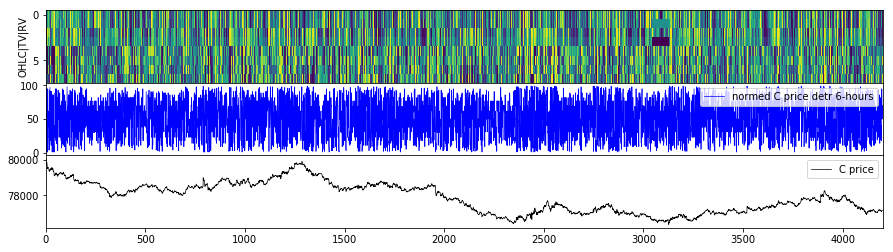

In [41]:
f, axr = plt.subplots(3, sharex=True, figsize=(15,4))
f.subplots_adjust(hspace=0)
axr[0].imshow(sbarsn.T[::-1], aspect='auto', cmap='viridis')
axr[0].set_ylabel('OHLC|TV|RV')
axr[1].plot(sbarsn[:, 3], 'b', lw=0.7, label='normed C price detr 6-hours') # close price
axr[2].plot(tbars.C.values, 'k', lw=0.7, label='C price') # close price
axr[1].legend()
axr[2].legend()
axr[2].set_xlim(0, ntime)

Get all possible patterns of `motifsize` using the last `ntime` minutes

In [42]:
# 45 minutes motifs
motifsize=3*60 # all substrings of this size are used as start

In [43]:
thbars = th.tensor(sbarsn, dtype=th.float32)
print(thbars.device)
npossible = len(thbars)-motifsize
pmotifs = th.zeros((len(thbars)-motifsize, motifsize, 8)) # possible motifs

for i in range(npossible):
    pmotifs[i] = thbars[i:i+motifsize, :]    
    ## pmotifs[i] -= th.mean(pmotifs[i], 0) doenst make sense on labeled classes
    #pmotifs[i] *= taper_han
    # remove 0 mean 
## dist_pmotifs = th.zeros((npossible, npossible+1)) # distance of all possible motifs

cpu


### Calculate lnorm from each possible motif sliding the original series to check for any recurrent pattern 

- this is the same as calculating distance between each possible motif
- forming a matrix of distances betwen motifs where diagonal is 0 zero
- then choosing motifs based on some distance threashold

In [44]:
pmotifs.shape

torch.Size([4020, 180, 8])

In [45]:
#@jit(nopython=True)
# def dist_matrix(npossible, pmotifs):
#     loss = th.nn.L1Loss(reduction='sum') # why not mean?
#     dist_matrix = th.zeros((npossible, npossible))
#     for i in range(npossible):
#         for j in range(npossible):
#             dist_matrix[i, j] = loss(pmotifs[i], pmotifs[j])
#     return dist_matrix
# doesnt need this pytorch has torch.cdist like `scipy.spatial.distance.cdist`

In [46]:
pmotifss = pmotifs.reshape(npossible, -1)

In [47]:
dist_matrix = th.cdist(pmotifss, pmotifss)

In [48]:
dist_matrix

tensor([[   0.0000, 1548.8112, 1536.8611,  ..., 1466.4675, 1519.8560,
         1502.0975],
        [1548.8112,    0.0000, 1542.7281,  ..., 1508.4631, 1467.9039,
         1519.7141],
        [1536.8611, 1542.7281,    0.0000,  ..., 1439.3141, 1507.8448,
         1467.9342],
        ...,
        [1466.4675, 1508.4631, 1439.3141,  ...,    0.0000, 1534.8612,
         1401.2644],
        [1519.8560, 1467.9039, 1507.8448,  ..., 1534.8612,    0.0000,
         1537.0052],
        [1502.0975, 1519.7141, 1467.9342,  ..., 1401.2644, 1537.0052,
            0.0000]])

In [49]:
raw_distances = (dist_matrix+th.eye(dist_matrix.shape[0])*th.mean(dist_matrix)).data.numpy().flatten()

In [50]:
np.percentile(raw_distances, [0, 3, 5, 10, 50, 90, 100])

array([1199.49035645, 1372.8532605 , 1386.15222168, 1407.03625488,
       1483.88305664, 1562.93212891, 1749.9708252 ])

In [51]:
argsort_dist_matrix = th.argsort(dist_matrix, 1) # first collum are distance with itself 
argsort_dist_matrix = argsort_dist_matrix[:, 1:] 

In [52]:
argsort_dist_matrix

tensor([[3637, 2182, 3325,  ..., 1149, 2401, 2409],
        [3638, 3326,  184,  ..., 1150, 2402, 2410],
        [3639,  185, 3327,  ..., 1151, 2411, 2403],
        ...,
        [ 603, 3408,  466,  ..., 2329, 2348, 2359],
        [ 604, 2163,  467,  ..., 1167, 2360, 2349],
        [ 605, 2164,   88,  ..., 1168, 2361, 2350]])

In [53]:
argsort_dist_matrix.shape

torch.Size([4020, 4019])

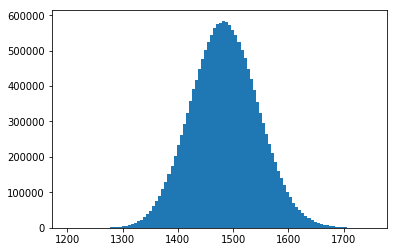

In [54]:
plt.hist(raw_distances, bins=100);

In [55]:
norm.fit(raw_distances)

(1484.5693, 60.577976)

In [56]:
p1 = np.percentile(raw_distances, [0.5])

In [57]:
p1

array([1334.47363098])

In [58]:
np.sort(raw_distances)

array([1199.4904, 1199.4904, 1202.8467, ..., 1746.2208, 1749.9708,
       1749.9708], dtype=float32)

In [76]:
p1 = np.percentile(raw_distances, [0.5])

### Use a threshold to get similar motifs - closer distances

- ignore patterns closer than half motif-size

In [77]:
motifsize, p1

(180, array([1334.47363098]))

In [78]:
threshold = th.tensor(p1, dtype=th.float32)
motifs = []
similars = []
for i in range(npossible):   # possible motifs       
    similars.clear()    
    for j in range(npossible-1):      
        distance = dist_matrix[i, argsort_dist_matrix[i, j]]
        distance2self = th.abs( argsort_dist_matrix[i, j] - i)
        #print(distance, distance2self)
        if(distance <= threshold and ( distance2self > motifsize/2 ) ):
            similars.append(argsort_dist_matrix[i, j].item())            
        else:
            break    
    motifs.append([i, np.sort(similars)])

In [79]:
motifs

[[0, array([], dtype=float64)],
 [1, array([], dtype=float64)],
 [2, array([], dtype=float64)],
 [3, array([], dtype=float64)],
 [4, array([], dtype=float64)],
 [5, array([], dtype=float64)],
 [6, array([], dtype=float64)],
 [7, array([], dtype=float64)],
 [8, array([3333, 3645])],
 [9, array([3334, 3646])],
 [10, array([3335, 3647])],
 [11, array([3336, 3648])],
 [12, array([3337, 3649])],
 [13, array([3338, 3650])],
 [14, array([3339])],
 [15, array([3340])],
 [16, array([3341])],
 [17, array([3342])],
 [18, array([3343])],
 [19, array([ 202, 3344])],
 [20, array([ 203, 3345, 3404])],
 [21, array([ 204, 3313, 3346, 3405])],
 [22, array([ 205, 3314, 3347, 3406])],
 [23, array([ 206,  465, 3315, 3348])],
 [24, array([ 207, 3316, 3349])],
 [25, array([ 208, 3317, 3350])],
 [26, array([3351])],
 [27, array([3352])],
 [28, array([3353, 3665])],
 [29, array([ 212, 3354, 3666])],
 [30, array([3322, 3355, 3667])],
 [31, array([2192, 3356, 3668])],
 [32, array([ 167, 2193, 3357])],
 [33, arra

In [80]:
dfmotifs = pd.DataFrame(motifs, columns=['motifi', 'indexes'])

In [81]:
dfmotifs.set_index(dfmotifs.motifi, drop=True, inplace=True)
dfmotifs.drop(columns='motifi', inplace=True)

### Remove 

1. all motifs without similars (not a motif)
2. motifs found closer than half-motifsize average it ??

In [82]:
dfmotifs = dfmotifs [ dfmotifs.indexes.apply(lambda x: len(x) > 0 ) ]

In [83]:
dfmotifs.head()

,indexes
motifi,
8,"[3333, 3645]"
9,"[3334, 3646]"
10,"[3335, 3647]"
11,"[3336, 3648]"
12,"[3337, 3649]"


In [95]:
dfmotifs [ dfmotifs.indexes.apply(lambda x: len(x) > 3 ) ]

,indexes
motifi,
21,"[204, 3313, 3346, 3405]"
22,"[205, 3314, 3347, 3406]"
23,"[206, 465, 3315, 3348]"
33,"[168, 2194, 3325, 3358]"
36,"[167, 171, 3328, 3361]"
37,"[168, 172, 3329, 3362]"
39,"[170, 174, 481, 507, 2163, 3331, 3364, 3679]"
40,"[171, 175, 206, 482, 508, 516, 3332, 3365, 3680]"
41,"[172, 176, 207, 483, 509, 2165, 3333, 3366, 34..."


In [96]:
cos = th.nn.CosineSimilarity(dim=0, eps=1e-6)

In [97]:
pmotifs.shape

torch.Size([4020, 180, 8])

In [98]:
cos(pmotifs[104], pmotifs[1])

tensor([0.7339, 0.7141, 0.7521, 0.7228, 0.8084, 0.7329, 0.7563, 0.7681])

In [99]:
cos(pmotifs[104], pmotifs[249])

tensor([0.8032, 0.7840, 0.8238, 0.7880, 0.8264, 0.7441, 0.8013, 0.7958])

In [100]:
# f, axr = plt.subplots(2, sharex=True, figsize=(16,6))
# f.subplots_adjust(hspace=0)
# axr[0].plot(np.arange(0, ntime*6, 6), sbars.H, lw=0.5)
# axr[0].plot(np.arange(0, ntime*6, 6), sbars.L, lw=0.5)
# axr[1].plot(sbars6d, lw=0.5)
# for j in [451]:
#     for i in range(len(saxbars.loc[j][1])):
#         mtfbg = saxbars.loc[j][1][i]
#         mtfbg_bar = saxbars.loc[j][1][i]//6 # convertion to original index bar series
#         axr[0].plot(np.arange(mtfbg, mtfbg+6*motifsize, 6), sbars.H[mtfbg_bar:mtfbg_bar+motifsize], 'r', lw=1)
#         axr[0].plot(np.arange(mtfbg, mtfbg+6*motifsize, 6), sbars.L[mtfbg_bar:mtfbg_bar+motifsize], 'r', lw=1)
#         axr[1].plot(np.arange(mtfbg, mtfbg+6*motifsize), sbars6d[mtfbg:mtfbg+(motifsize*6)], 'r', lw=0.8)

In [101]:
smotifs = dfmotifs [ dfmotifs.indexes.apply(lambda x: len(x) > 4 ) ]

In [102]:
smotifs

,indexes
motifi,
39,"[170, 174, 481, 507, 2163, 3331, 3364, 3679]"
40,"[171, 175, 206, 482, 508, 516, 3332, 3365, 3680]"
41,"[172, 176, 207, 483, 509, 2165, 3333, 3366, 34..."
42,"[173, 208, 484, 510, 2166, 3334, 3367, 3657, 3..."
43,"[174, 178, 209, 485, 511, 519, 2167, 3335, 336..."
44,"[175, 179, 197, 207, 210, 381, 486, 512, 520, ..."
45,"[176, 180, 186, 198, 208, 211, 382, 487, 513, ..."
46,"[177, 181, 187, 209, 212, 223, 383, 488, 514, ..."
47,"[178, 182, 210, 213, 224, 384, 489, 515, 523, ..."


In [103]:
@jit(nopython=True)
def rrepeated(lst, insert_count=-1):
    """ get the center values of incremented by 1 values"""
    before = lst[0]
    newlst = []
    mean=before
    count=1
    for v in lst[1:]:    
        if (v-before) != 1:
            if insert_count != -1:
                newlst.append([int(np.floor(mean/count)), count])
            else:
                newlst.append([int(np.floor(mean/count))]) 
            mean=v
            count=0
        else:        
            mean += v
        before = v
        count +=1
    if insert_count != -1:
        newlst.append([int(np.floor(mean/count)), count])
    else:
        newlst.append([int(np.floor(mean/count))]) # last
    return newlst

In [104]:
#smotifs.iloc[1][0]

In [105]:
#smotifs.iloc[1][0]

In [106]:
smotifs.loc[:, 'indexes'] = smotifs.indexes.apply(lambda x: np.array(rrepeated(x)).flatten()).values
smotifs.loc[:, 'count'] = smotifs.indexes.apply(lambda x: len(x))

D:\Users\andre.ferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
D:\Users\andre.ferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\Users\andre.ferreira\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be

In [107]:
smotifs.sort_values(by='count', ascending=False) # 4 or 5 times shown

,indexes,count
motifi,,
3654,"[110, 117, 128, 132, 135, 138, 146, 151, 154, ...",56
3656,"[112, 119, 123, 130, 134, 137, 140, 148, 156, ...",54
3655,"[111, 118, 129, 133, 136, 139, 147, 155, 171, ...",48
3657,"[113, 120, 124, 131, 135, 138, 141, 149, 157, ...",47
3658,"[114, 121, 125, 132, 136, 139, 142, 150, 158, ...",46
3659,"[115, 122, 126, 133, 137, 141, 143, 151, 159, ...",43
3694,"[79, 109, 150, 161, 168, 176, 178, 187, 189, 2...",43
3675,"[60, 90, 131, 138, 149, 157, 159, 167, 170, 17...",43
3642,"[116, 120, 124, 126, 134, 139, 142, 147, 152, ...",42


In [108]:
npossible

4020

In [109]:
smotifs.index[11], smotifs.iloc[11]

(50, indexes    [181, 492, 518, 3342, 3375]
 count                                5
 Name: 50, dtype: object)

In [110]:
smotifs

,indexes,count
motifi,,
39,"[170, 174, 481, 507, 2163, 3331, 3364, 3679]",8
40,"[171, 175, 206, 482, 508, 516, 3332, 3365, 3680]",9
41,"[172, 176, 207, 483, 509, 2165, 3333, 3366, 34...",10
42,"[173, 208, 484, 510, 2166, 3334, 3367, 3657, 3...",9
43,"[174, 178, 209, 485, 511, 519, 2167, 3335, 336...",11
44,"[175, 179, 197, 207, 210, 381, 486, 512, 520, ...",16
45,"[176, 180, 186, 198, 208, 211, 382, 487, 513, ...",19
46,"[177, 181, 187, 209, 212, 223, 383, 488, 514, ...",20
47,"[178, 182, 210, 213, 224, 384, 489, 515, 523, ...",18


In [113]:
smotifs.iloc[580]

indexes    [112, 123, 141, 154, 159, 167, 169, 178, 182, ...
count                                                     33
Name: 2208, dtype: object

(0, 4200)

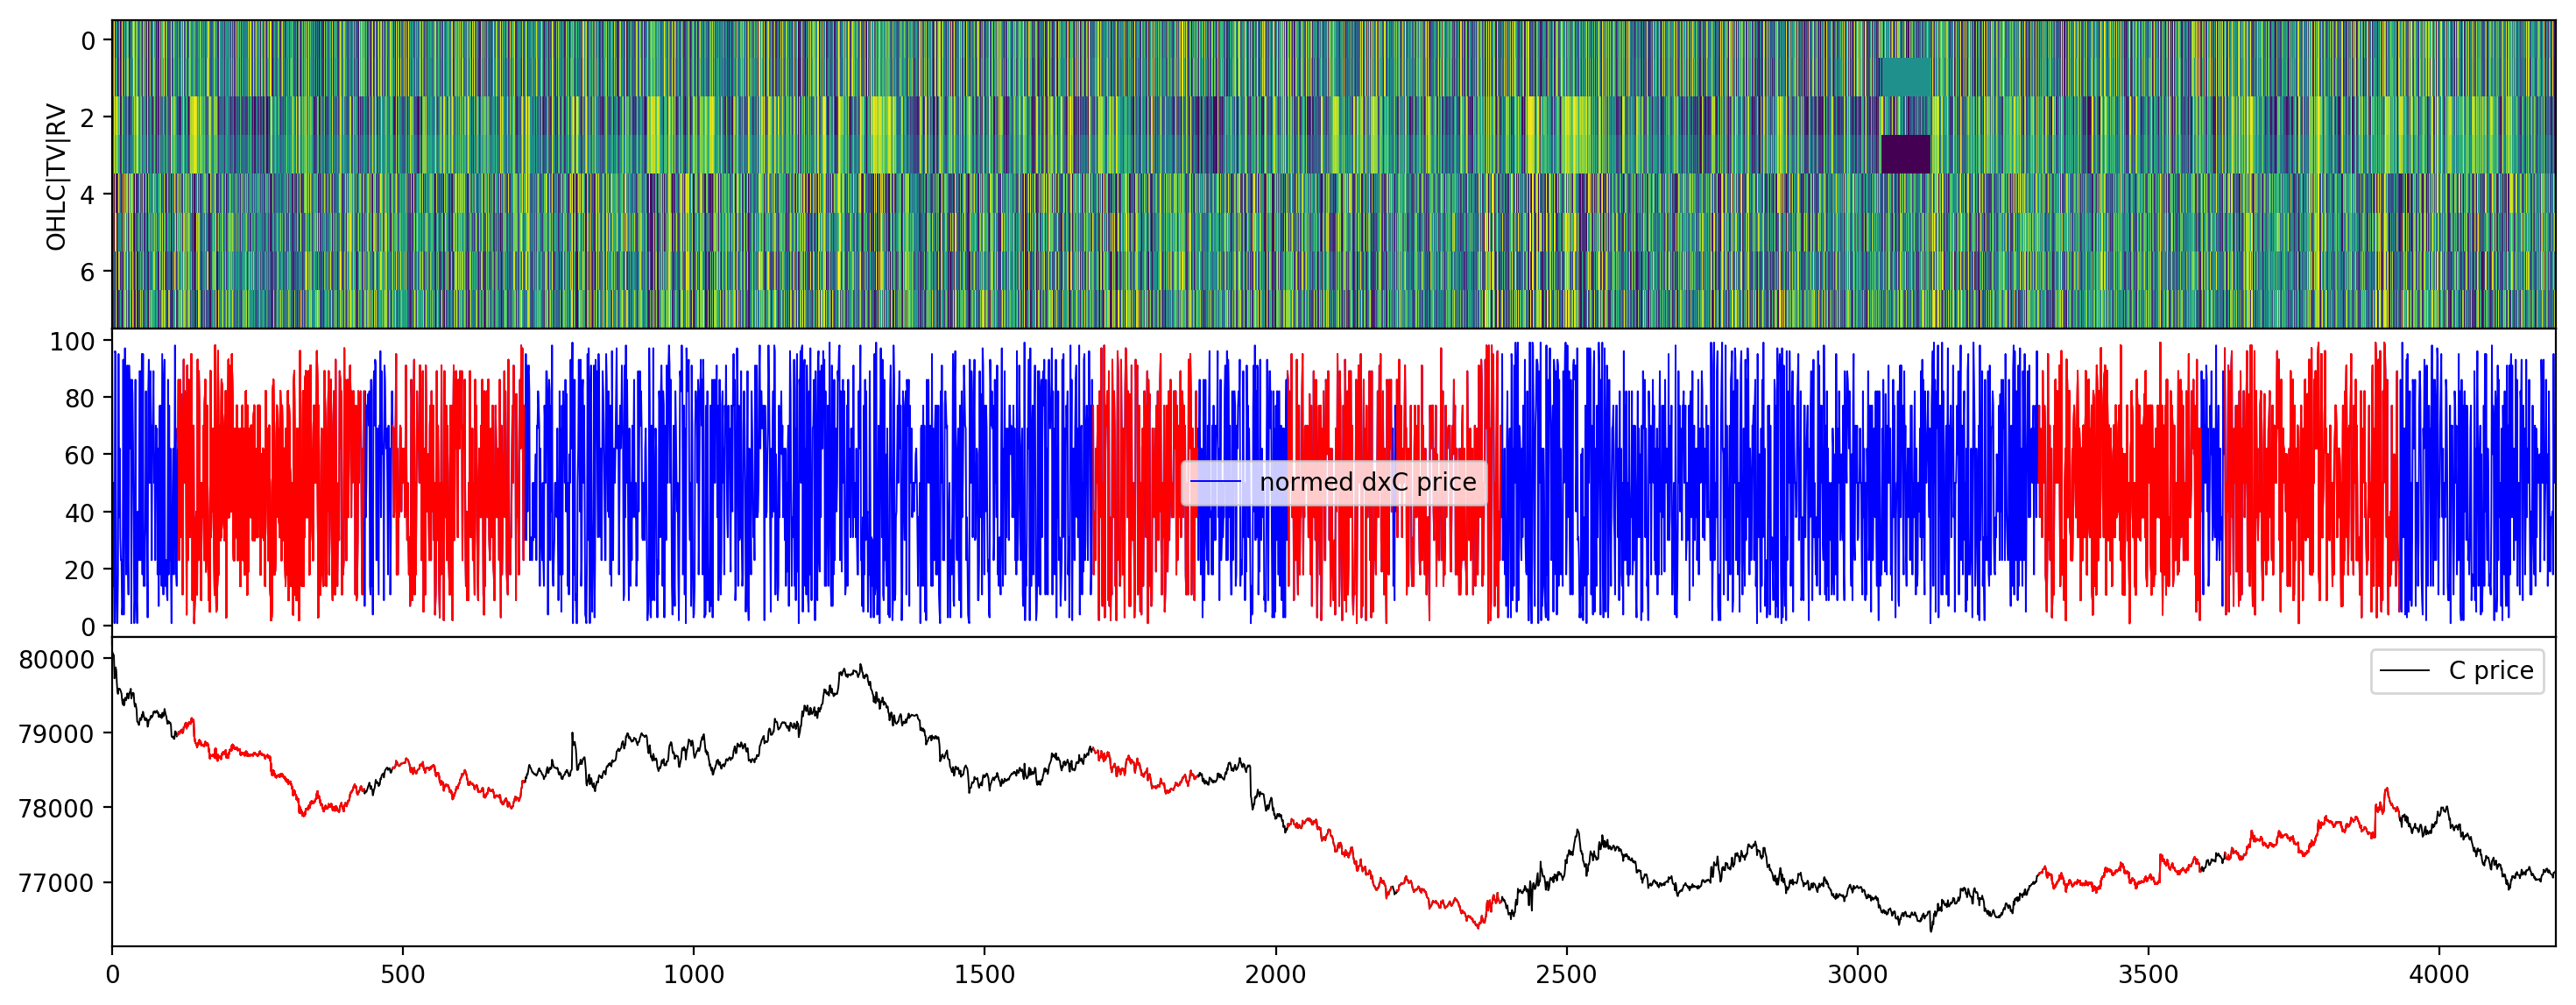

In [111]:
f, axr = plt.subplots(3, sharex=True, figsize=(18,7), dpi=200)
f.subplots_adjust(hspace=0)
axr[0].imshow(sbarsn.T[::-1], aspect='auto', cmap='viridis')
axr[0].set_ylabel('OHLC|TV|RV')
axr[1].plot(sbarsn[:, 3], 'b', lw=0.7, label='normed dxC price') # close price
axr[2].plot(tbars.C.values, 'k', lw=0.7, label='C price') # close price
#axr[2].plot(tbars.CEMA.values, 'b', lw=0.5, label='CEMA price') # close price

for i in [580]:
    dad = smotifs.index[i]
    axr[1].plot(np.arange(dad, dad+motifsize), sbarsn[dad:dad+motifsize, 3], 'r', lw=0.7) # close price
    axr[2].plot(np.arange(dad, dad+motifsize), tbars.C.values[dad:dad+motifsize], 'r', lw=0.7) # close price
    nsons = len(smotifs.iloc[i, 0])
    for son in smotifs.iloc[i, 0]:
        axr[1].plot(np.arange(son, son+motifsize), sbarsn[son:son+motifsize, 3], 'r', lw=0.7) # close price  
        axr[2].plot(np.arange(son, son+motifsize), tbars.C.values[son:son+motifsize], 'r', lw=0.7) # close price        

axr[1].legend()
axr[2].legend()
axr[2].set_xlim(0, ntime)